In [1]:
import sys
from os.path import join as pjoin
from itertools import product
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import pymc as pm
import seaborn as sns
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path

d = Path().resolve().parent
sys.path.append(str(d))
import utils

sns.set_context("notebook")
sns.set_style("whitegrid")
utils.DATA_DIR = r"C:\WorkSpace\data\tc"

Open the TCGP dataset that holds the environmental variables and transform to monthly mean values.

In [2]:
ds = xr.open_dataset(r"C:\WorkSpace\tropical_cyclone_risk\data\era5\tcgp_era5_198101_202112.nc")
dsmean = ds.groupby(ds.time.dt.month).mean(dim="time")

Load the IBTrACS data and sample the monthly mean TCGP data at the genesis points.

In [3]:
df = utils.load_ibtracs_df()
df = df[(df.SEASON > 1980) & (df.SEASON < 2024)]
nseasons = df.SEASON.max() - df.SEASON.min() + 1
groupdf = df.groupby("DISTURBANCE_ID")
recs = []
for name, group in groupdf:
    # Filter the group for records where MAX_WIND_SPD exceeds the threshold
    exceeding_records = group[group["MAX_WIND_SPD"] >= 34]

    # If there are any records exceeding the threshold, select the first one
    if not exceeding_records.empty:
        rec = exceeding_records.iloc[0]
        recs.append(rec)

gpdf = pd.DataFrame(recs)
gx = xr.DataArray(gpdf['LON'])
gy = xr.DataArray(gpdf['LAT'])
gt = xr.DataArray(gpdf['TM'].dt.month)
df = dsmean.sel(month=gt, longitude=gx, latitude=gy, method="nearest").to_dataframe()


Number of TC records: 137983


Calculate the number of storms forming in each grid box. We start here with a $2.5 \times 2.5^{\circ}$ grid from $30^{\circ}\mathrm{S}$ to $30^{\circ}\mathrm{N}$. We perform a count for each month of the year.

In [4]:
# Calculate number of storms in each grid box
edge_lats = np.arange(-30, 30.1, 2.5)
edge_lons = np.arange(0, 360.1, 2.5)
clats = edge_lats[:-1] + 1.25
clons = edge_lons[:-1] + 1.25
hh = np.zeros((12, len(clons), len(clats)))

for month in range(1, 13):
    tmpdf = gpdf.loc[gpdf.TM.dt.month==month]
    x = tmpdf['LON']
    y = tmpdf['LAT']
    hh[month-1, :, :], xbin, ybin = np.histogram2d(x, y, bins=[edge_lons, edge_lats], density=False)

# Divide by total number of seasons
#hh = hh / nseasons
ntcs = hh.flatten()

Convert the counts to an `xr.DataArray`

In [5]:
tcg = xr.DataArray(
    data=hh,
    coords = {
        'month': np.arange(1, 13),
        'longitude': clons,
        'latitude': clats
    },
    dims=['month', 'longitude', 'latitude'],
    attrs={
        'Description': "Mean number of TC genesis points",
        'units': "TCs/year",
        'data_source': "IBTraCS v4.0",
    })

In [6]:
sum_tcgp = np.zeros((12, len(edge_lons), len(edge_lats)))
sum_shear = np.zeros((12, len(edge_lons), len(edge_lats)))
sum_rh = np.zeros((12, len(edge_lons), len(edge_lats)))
sum_xi = np.zeros((12, len(edge_lons), len(edge_lats)))
sum_vmax = np.zeros((12, len(edge_lons), len(edge_lats)))
count = np.zeros((12, len(edge_lons), len(edge_lats)))

for index, row in df.iterrows():
    if (row['latitude'] < edge_lats.min()) | (row['latitude'] >= edge_lats.max()):
        continue
    if (row['longitude'] < edge_lons.min()) | (row['longitude'] >= edge_lons.max()):
        continue
    if (np.isnan(row['tcgp'])): # | (row['vmax']== np.nan):
        continue
    month_index = int(row['month']) - 1
    lat_index = int((row['latitude'] - edge_lats.min()) // 2.5)
    lon_index = int((row['longitude'] - edge_lons.min()) // 2.5)
    sum_tcgp[month_index, lon_index, lat_index] += row['tcgp']
    sum_vmax[month_index, lon_index, lat_index] += row['vmax']
    sum_rh[month_index, lon_index, lat_index] += row['rh']
    sum_shear[month_index, lon_index, lat_index] += row['shear']
    sum_xi[month_index, lon_index, lat_index] += row['xi']
    count[month_index, lon_index, lat_index] += 1

In [7]:
average_tcgp = np.divide(sum_tcgp, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_vmax = np.divide(sum_vmax, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_rh = np.divide(sum_rh, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_shear = np.divide(sum_shear, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_xi = np.divide(sum_xi, count, out=np.zeros_like(sum_tcgp), where=count!=0)

tcgp = average_tcgp.flatten()
shear = average_shear.flatten()
xi = average_xi.flatten()
vpot = average_vmax.flatten()
rh = average_rh.flatten()
ntcs = count.flatten()
nu = np.maximum((vpot / 40) - 1, 0)
mu = np.maximum((xi / 2e-5) - 1, 0)
rho = np.maximum((rh / 40) - 1, 0)
sigma = np.maximum((1 - (shear / 20)), 0)
X = np.vstack([np.ones(len(nu)), nu, mu, rho, sigma]).T

First try Bayesian methods to determine the optmal model fit. We assume a Poisson distribution of the predictand (i.e. number of TCs in a grid cell). 

$P(N_{TC}=n) = \dfrac{e^{-\mu}\mu^{n}}{n!}$ where

$\mu = \exp(\beta X)$

$X$ represents the vector of predictors - our scaled variables defined above. This model is based on the TC genesis parameters variously reported in the literature - for example, Tippett _et al_. (2011), Nolan and Emanuel (2004). 

Fairly uninformative priors are used, as we are confident in the choice of parameters but the literature weights these differently. 

In [8]:
with pm.Model() as tcgpmodel:
    b0 = pm.Normal("Intercept", mu=0, sigma=10)
    b1 = pm.Normal("nu", mu=0, sigma=1)
    b2 = pm.Normal("mu", mu=0, sigma=1)
    b3 = pm.Normal("rho", mu=0, sigma=1)
    b4 = pm.Normal("sigma", mu=0, sigma=1)

    theta = (
        b0 +
        b1 * nu +
        b2 * mu +
        b3 * rho +
        b4 * sigma)
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=ntcs)

    step = pm.Metropolis()
    trace = pm.sample(10_000, tune=2000, step=step, return_inferencedata=True, chains=4, cores=1, idata_kwargs={"log_likelihood": True})
    trace.extend(pm.sample_posterior_predictive(trace))

Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [Intercept]
>Metropolis: [nu]
>Metropolis: [mu]
>Metropolis: [rho]
>Metropolis: [sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 881 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


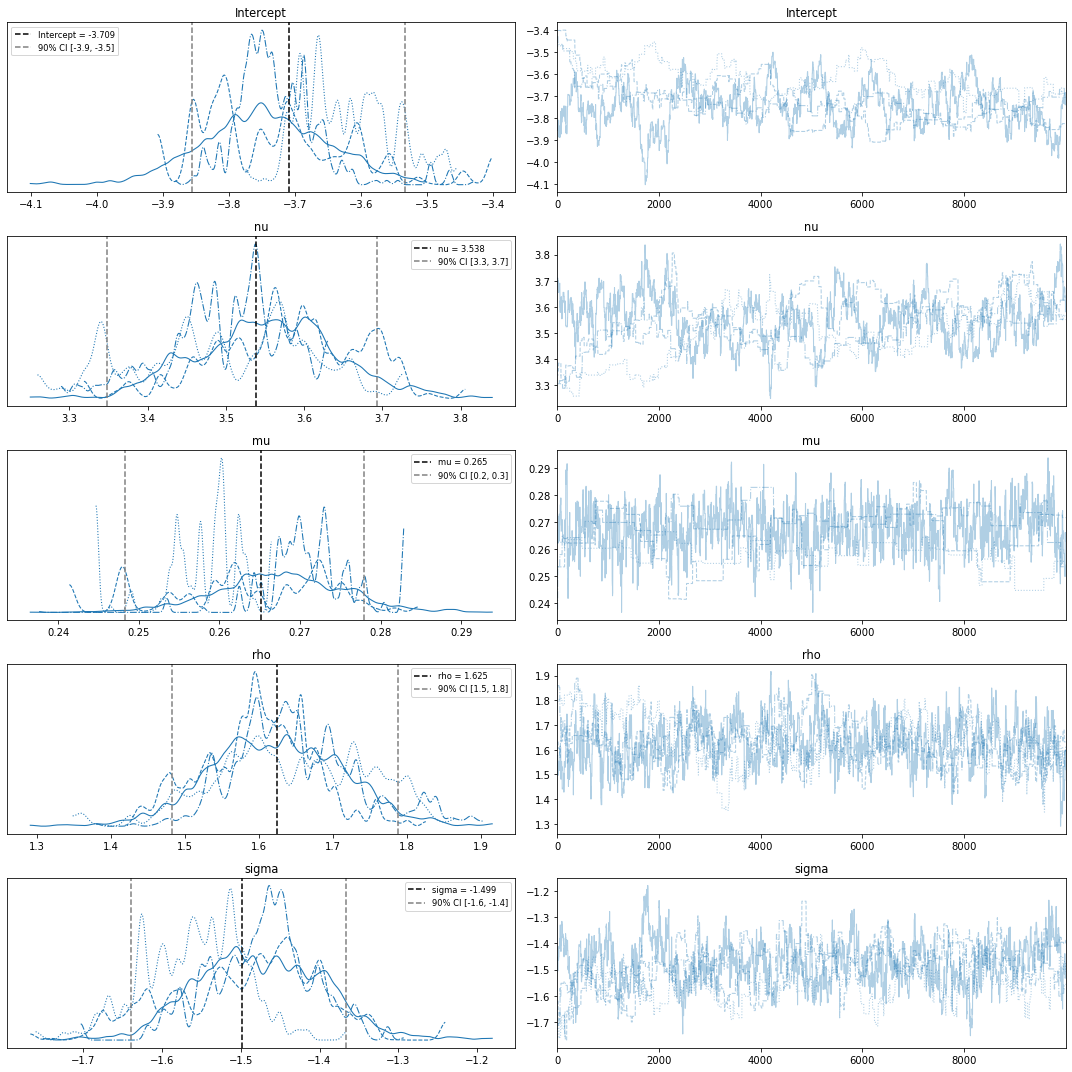

In [9]:
axes = az.plot_trace(trace,  var_names=('Intercept', 'nu', 'mu','rho','sigma'), legend=True, divergences='top', figsize=(15, 15))
var_names = ['Intercept', 'nu', 'mu','rho','sigma']
qq = [np.quantile(trace.posterior[v], [0.05, 0.5, 0.95]) for v in var_names]

for i, v in enumerate(var_names):
    axes[i, 0].axvline(qq[i][1], ls='--', color='k',
                    label=f'{v} = {qq[i][1]:.3f}')
    axes[i, 0].axvline(qq[i][0], ls='--', color='gray',
                    label=f"90% CI [{qq[i][0]:.1f}, {qq[i][2]:.1f}]")
    axes[i, 0].axvline(qq[i][2], ls='--', color='gray')
    axes[i, 0].legend(fontsize='small')


plt.tight_layout()

In [40]:
from sklearn.linear_model import PoissonRegressor, LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, 1:], ntcs, test_size=0.2)
pmdl = PoissonRegressor(fit_intercept=False)
pmdl.fit(X_train, y_train)
pmdl.intercept_, pmdl.coef_

(0.0, array([ 0.02512243,  0.09088126,  0.01647424, -0.53591211]))

In [34]:
pmdl.score(X_test, y_test)

-1.100276317304714

In [89]:
lmdl = LinearRegression()
lmdl.fit(X_train, y_train)
lmdl.intercept_, lmdl.coef_

(-0.37889422857685956, array([0.53514482, 0.16967536, 1.56114808, 0.37963282]))

In [90]:
lmdl.score(X_test, y_test)

0.7059062906900062

In [91]:
from copy import copy
import cartopy.crs as ccrs
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

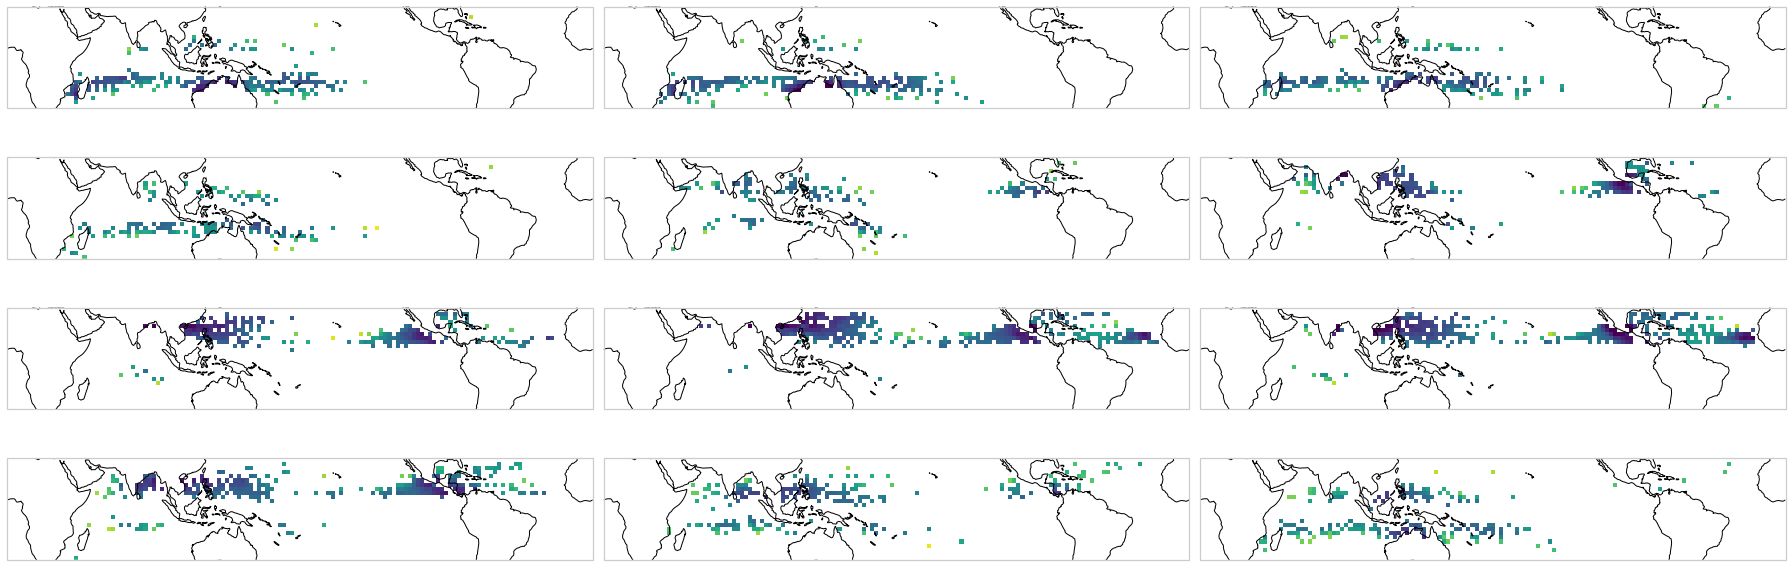

In [102]:
output = lmdl.predict(X[:, 1:]).reshape(count.shape)
fig, axes = plt.subplots(4, 3, figsize=(25, 9), subplot_kw={"projection": projection})
palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 0.1)
for i, ax in enumerate(axes.flatten()):
    cs = ax.pcolormesh(edge_lons, edge_lats, output[i,:,:].T, cmap=palette, vmin=0.1, vmax=2.5, transform=transform)
    ax.coastlines()
fig.tight_layout()

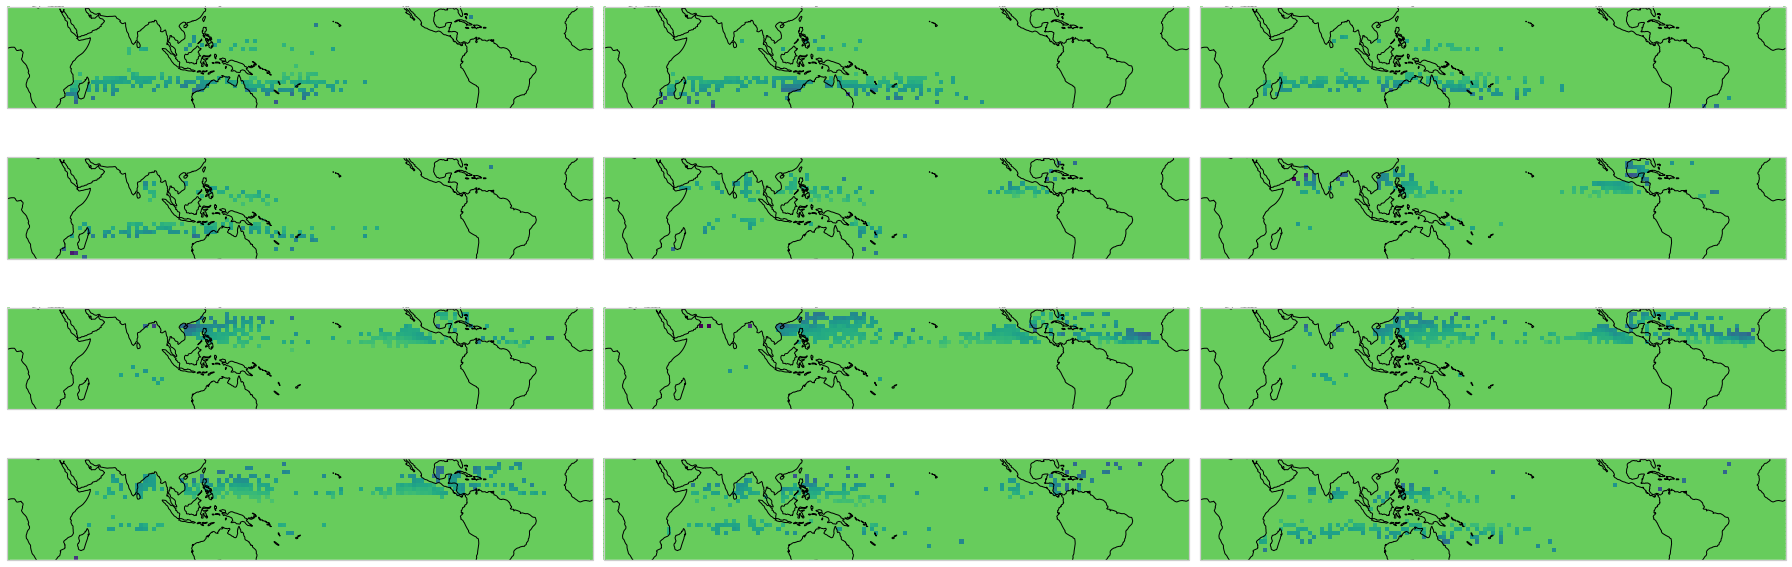

In [74]:
output = pmdl.predict(X[:, 1:]).reshape(count.shape)
fig, axes = plt.subplots(4, 3, figsize=(25, 9), subplot_kw={"projection": projection})
palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 0.001)
for i, ax in enumerate(axes.flatten()):
    cs = ax.pcolormesh(edge_lons, edge_lats, output[i,:,:].T, cmap=palette, vmin=0.001, vmax=2.5, transform=transform)
    ax.coastlines()
fig.tight_layout()

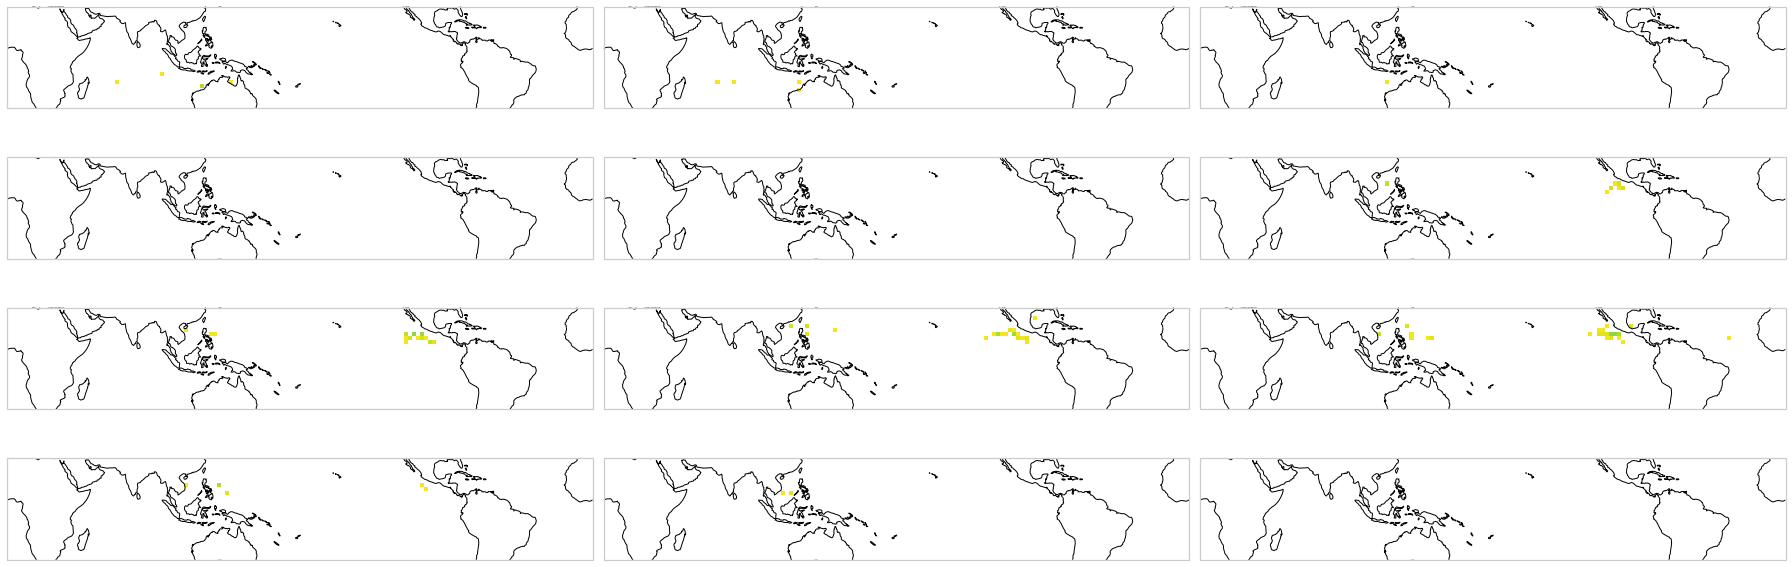

In [101]:
output = ntcs.reshape(count.shape)
fig, axes = plt.subplots(4, 3, figsize=(25, 9), subplot_kw={"projection": projection})
palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 0.1)
for i, ax in enumerate(axes.flatten()):
    cs = ax.pcolormesh(edge_lons, edge_lats, (output[i,:,:]/nseasons).T, cmap=palette, vmin=0.1, vmax=1, transform=transform)
    ax.coastlines()
fig.tight_layout()